In [14]:
from google.colab import drive

# Google Driveをマウント
drive.mount('/content/drive')

# マウント完了後のメッセージ
print("Google Driveがマウントされました！")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Driveがマウントされました！


# lightgbmでトレーニングする

In [15]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve


# データ読み込み
file_path = '/content/drive/My Drive/signate/train_1221_5.csv'
df = pd.read_csv(file_path, low_memory=False)

# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# 特徴量とターゲット
X = df.drop(columns=['loan_status', 'grade', 'term_months'])
y = df['loan_status']

# データ分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# LightGBMパラメータ（学習率を下げる）
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,  # 学習率を下げる
    'num_leaves': 31,
    'max_depth': 8,
    'verbose': -1
}

# クロスバリデーションの設定
n_splits = 5  # 分割数
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

f1_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}/{n_splits}")

    # トレーニングデータと検証データの分割
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # データセットの作成
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
    valid_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_columns, reference=train_data)

    # モデルの学習
    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        num_boost_round=5000,  # イテレーション数を増やす
        callbacks=[lgb.early_stopping(150), lgb.log_evaluation(50)]
    )

    # 検証データの予測確率
    y_val_proba = model.predict(X_val)

    # 最適な閾値を計算
    precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
    f1_fold = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]
    best_threshold = thresholds[f1_fold.index(max(f1_fold))]
    print(f"Best Threshold: {best_threshold}")

    # 最適な閾値で評価
    y_val_pred = (y_val_proba > best_threshold).astype(int)
    f1 = f1_score(y_val, y_val_pred)
    f1_scores.append(f1)

    print(f"Fold {fold + 1} F1 Score: {f1}")

# 平均F1スコア
mean_f1 = sum(f1_scores) / len(f1_scores)
print(f"\nMean F1 Score across folds: {mean_f1}")


# モデルを保存
model_file_path = '/content/drive/My Drive/signate/lgbm_model_1221_5.txt'
model.save_model(model_file_path)
print(f"Model saved to: {model_file_path}")



Fold 1/5
Training until validation scores don't improve for 150 rounds
[50]	valid_0's binary_logloss: 0.45921
[100]	valid_0's binary_logloss: 0.45827
[150]	valid_0's binary_logloss: 0.457882
[200]	valid_0's binary_logloss: 0.457774
[250]	valid_0's binary_logloss: 0.457812
[300]	valid_0's binary_logloss: 0.457922
Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.457746
Best Threshold: 0.222741858591458
Fold 1 F1 Score: 0.42507082152974507
Fold 2/5
Training until validation scores don't improve for 150 rounds
[50]	valid_0's binary_logloss: 0.457488
[100]	valid_0's binary_logloss: 0.456661
[150]	valid_0's binary_logloss: 0.456479
[200]	valid_0's binary_logloss: 0.456255
[250]	valid_0's binary_logloss: 0.456321
[300]	valid_0's binary_logloss: 0.456495
[350]	valid_0's binary_logloss: 0.456683
Early stopping, best iteration is:
[214]	valid_0's binary_logloss: 0.456165
Best Threshold: 0.2196114904168643
Fold 2 F1 Score: 0.42408266554196544
Fold 3/5
Training until validation

# 最適な閾値を決定する

In [16]:
# 全ての検証データで予測
y_val_proba = model.predict(X_val)  # X_valはすべての検証データ
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

# 最適F1スコアの閾値
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]
best_threshold = thresholds[f1_scores.index(max(f1_scores))]
print(f"Best Threshold (overall validation): {best_threshold}")


Best Threshold (overall validation): 0.19726323890446196


In [6]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


# optunaで最適なパラメータを探す

In [7]:
import pandas as pd
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold
import optuna

# データ読み込み
file_path = '/content/drive/My Drive/signate/train_1221_3.csv'
df = pd.read_csv(file_path, low_memory=False)

# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# 特徴量とターゲット
X = df.drop(columns=['loan_status', 'grade', 'term_months'])
y = df['loan_status']

# クロスバリデーションの設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optunaによるハイパーパラメータ探索の設定
def objective(trial):
    # ハイパーパラメータを探索
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 16),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10),
        'verbose': -1
    }

    # クロスバリデーションで最適なイテレーションを計算
    iterations = []
    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
        valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_columns)

        model = lgb.train(
            params,
            train_data,
            valid_sets=[valid_data],
            num_boost_round=1000,
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(50)
            ]
        )

        iterations.append(model.best_iteration)

    # 最適なブースト回数の平均を返す
    return sum(iterations) / len(iterations)

# Optunaで最適化
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 最適なハイパーパラメータを表示
print("Best parameters:", study.best_params)

# 最適なパラメータで再トレーニング
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_logloss'
best_params['boosting_type'] = 'gbdt'
best_params['verbose'] = -1

# 最適なイテレーション数を取得
best_num_boost_round = int(study.best_value)

# 全データでモデルをトレーニング
train_data = lgb.Dataset(X, label=y, categorical_feature=categorical_columns)
final_model = lgb.train(best_params, train_data, num_boost_round=best_num_boost_round)



[I 2024-12-21 02:56:26,889] A new study created in memory with name: no-name-c82858e7-e7fb-4a79-a537-19a43c31dcd6
<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugges

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.791957
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.497415
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.790068
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.497316
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.792493
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.497332
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.791683
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.49719
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 02:56:30,716] Trial 0 finished with value: 2.0 and parameters: {'learning_rate': 0.03408827324003469, 'num_leaves': 125, 'max_depth': 5, 'min_data_in_leaf': 93, 'lambda_l1': 1.01383272154143e-07, 'lambda_l2': 7.709999396722366, 'feature_fraction': 0.9636582176214619, 'bagging_fraction': 0.9556814202270122, 'bagging_freq': 7, 'scale_pos_weight': 9.990439027775338}. Best is trial 0 with value: 2.0.


[50]	valid_0's binary_logloss: 0.790587
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.497294


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.917761
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.499153
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.915685
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.499087
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.91765
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.499124
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.916751
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.499056


[I 2024-12-21 02:56:32,337] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.054061769333314594, 'num_leaves': 88, 'max_depth': 1, 'min_data_in_leaf': 59, 'lambda_l1': 9.97103734251025, 'lambda_l2': 1.654797265519925e-05, 'feature_fraction': 0.7286110580965596, 'bagging_fraction': 0.9610199997297336, 'bagging_freq': 2, 'scale_pos_weight': 9.826351047473457}. Best is trial 0 with value: 2.0.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.915326
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.499056


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.738004
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.49438
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.733944
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.494537
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.737485
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.494872
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.736248
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.494541
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 02:56:39,050] Trial 2 finished with value: 2.0 and parameters: {'learning_rate': 0.058988619971881213, 'num_leaves': 179, 'max_depth': 7, 'min_data_in_leaf': 58, 'lambda_l1': 0.00014911549858783816, 'lambda_l2': 0.12256178164190985, 'feature_fraction': 0.7178524778565865, 'bagging_fraction': 0.7708579117548046, 'bagging_freq': 2, 'scale_pos_weight': 6.362105086747902}. Best is trial 0 with value: 2.0.


[50]	valid_0's binary_logloss: 0.735153
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.494533


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.618062
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.496697
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.616239
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.496623
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.618654
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.496678
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.617185
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.496574


[I 2024-12-21 02:56:40,433] Trial 3 finished with value: 1.0 and parameters: {'learning_rate': 0.07786354745034649, 'num_leaves': 138, 'max_depth': 1, 'min_data_in_leaf': 12, 'lambda_l1': 0.010006280255349135, 'lambda_l2': 0.022212039664889594, 'feature_fraction': 0.9802003242504727, 'bagging_fraction': 0.8805985314898485, 'bagging_freq': 7, 'scale_pos_weight': 3.6657891039797903}. Best is trial 0 with value: 2.0.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.617084
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.49657


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.558144
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.490587
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.55607
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.490298
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.558838
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.490779
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.557102
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.490159
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 02:56:42,601] Trial 4 finished with value: 4.0 and parameters: {'learning_rate': 0.05102238173468059, 'num_leaves': 208, 'max_depth': 4, 'min_data_in_leaf': 93, 'lambda_l1': 4.786528431197132e-07, 'lambda_l2': 0.0025456369159613484, 'feature_fraction': 0.8501560204468218, 'bagging_fraction': 0.7540633277906141, 'bagging_freq': 3, 'scale_pos_weight': 3.06563237649204}. Best is trial 4 with value: 4.0.


[50]	valid_0's binary_logloss: 0.557066
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.49046


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.824061
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.494832
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.819778
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.494812
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.822262
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.494983
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.822844
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.494973
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 02:56:46,937] Trial 5 finished with value: 1.0 and parameters: {'learning_rate': 0.06524953701005676, 'num_leaves': 248, 'max_depth': 11, 'min_data_in_leaf': 21, 'lambda_l1': 0.06155838573320334, 'lambda_l2': 2.967576965378611e-08, 'feature_fraction': 0.8043712590151383, 'bagging_fraction': 0.7168063875473881, 'bagging_freq': 1, 'scale_pos_weight': 8.458357912649014}. Best is trial 4 with value: 4.0.


[50]	valid_0's binary_logloss: 0.820367
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.495031


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.46343
[100]	valid_0's binary_logloss: 0.461391
[150]	valid_0's binary_logloss: 0.460085
[200]	valid_0's binary_logloss: 0.459498
[250]	valid_0's binary_logloss: 0.459167
[300]	valid_0's binary_logloss: 0.458935
[350]	valid_0's binary_logloss: 0.458852
[400]	valid_0's binary_logloss: 0.458986
Early stopping, best iteration is:
[353]	valid_0's binary_logloss: 0.458828
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.461981
[100]	valid_0's binary_logloss: 0.460104
[150]	valid_0's binary_logloss: 0.458418
[200]	valid_0's binary_logloss: 0.458058
[250]	valid_0's binary_logloss: 0.457866
[300]	valid_0's binary_logloss: 0.457587
[350]	valid_0's binary_logloss: 0.457465
[400]	valid_0's binary_logloss: 0.45725
Early stopping, best iteration is:
[386]	valid_0's binary_logloss: 0.457218
Training until validation scores don't improve for 50 rounds
[50]	valid_0'

[I 2024-12-21 02:57:01,944] Trial 6 finished with value: 504.2 and parameters: {'learning_rate': 0.0767667358471195, 'num_leaves': 140, 'max_depth': 4, 'min_data_in_leaf': 11, 'lambda_l1': 1.024952107767434e-08, 'lambda_l2': 0.017104295921181577, 'feature_fraction': 0.7141040531915351, 'bagging_fraction': 0.7170311156855347, 'bagging_freq': 8, 'scale_pos_weight': 1.1109824293188328}. Best is trial 6 with value: 504.2.


[600]	valid_0's binary_logloss: 0.457476
Early stopping, best iteration is:
[568]	valid_0's binary_logloss: 0.457352


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.499283
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.487063
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.497978
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.486565
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.50003
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.487327
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.49838
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.486571
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 02:57:03,883] Trial 7 finished with value: 15.2 and parameters: {'learning_rate': 0.028410692866219833, 'num_leaves': 162, 'max_depth': 3, 'min_data_in_leaf': 100, 'lambda_l1': 0.1270208781215522, 'lambda_l2': 0.06987454232599828, 'feature_fraction': 0.9736429136240279, 'bagging_fraction': 0.7926068578662366, 'bagging_freq': 1, 'scale_pos_weight': 2.17891135151811}. Best is trial 6 with value: 504.2.


[50]	valid_0's binary_logloss: 0.498862
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.486944


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.584526
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.494265
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.582771
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.494003
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.58427
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.494279
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.583407
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.493947
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 02:57:11,156] Trial 8 finished with value: 5.8 and parameters: {'learning_rate': 0.01790342973600778, 'num_leaves': 142, 'max_depth': 11, 'min_data_in_leaf': 13, 'lambda_l1': 0.5340323437751452, 'lambda_l2': 0.00044875729083703993, 'feature_fraction': 0.7921709680677005, 'bagging_fraction': 0.7038220239177346, 'bagging_freq': 2, 'scale_pos_weight': 6.8698501164875}. Best is trial 6 with value: 504.2.


[50]	valid_0's binary_logloss: 0.583155
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.494281


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.576953
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.497304
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.575885
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.497227
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.576787
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.49738
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.576044
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.497239
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 02:57:13,090] Trial 9 finished with value: 5.0 and parameters: {'learning_rate': 0.013153267725062473, 'num_leaves': 50, 'max_depth': 3, 'min_data_in_leaf': 29, 'lambda_l1': 4.570335553971916e-06, 'lambda_l2': 0.0017037832971156636, 'feature_fraction': 0.8135022135062756, 'bagging_fraction': 0.7247246500178622, 'bagging_freq': 3, 'scale_pos_weight': 7.905888589710813}. Best is trial 6 with value: 504.2.


[50]	valid_0's binary_logloss: 0.575862
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.497272


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.45886
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.45874
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.457111
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.457072
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.460729
[100]	valid_0's binary_logloss: 0.461388
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.46071
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.457709
[100]	valid_0's binary_logloss: 0.458291
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.457709
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.458646
[100]	valid_0's binary_logloss: 0.458623
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.458408


[I 2024-12-21 02:57:18,483] Trial 10 finished with value: 53.0 and parameters: {'learning_rate': 0.09815831582392803, 'num_leaves': 87, 'max_depth': 16, 'min_data_in_leaf': 41, 'lambda_l1': 1.2161662253529961e-08, 'lambda_l2': 4.460287404494311e-06, 'feature_fraction': 0.8622020908870579, 'bagging_fraction': 0.8447249727509212, 'bagging_freq': 10, 'scale_pos_weight': 1.1372510703001455}. Best is trial 6 with value: 504.2.
<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.458953
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.458895
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.456741
[100]	valid_0's binary_logloss: 0.457298
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.456718
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.460545
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.460338
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.457526
[100]	valid_0's binary_logloss: 0.457595
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.457417
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.458528
[100]	valid_0's binary_logloss: 0.458481
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.4582

[I 2024-12-21 02:57:26,476] Trial 11 finished with value: 53.8 and parameters: {'learning_rate': 0.09858071494155553, 'num_leaves': 84, 'max_depth': 16, 'min_data_in_leaf': 40, 'lambda_l1': 1.2035894522403987e-08, 'lambda_l2': 4.5340055078582696e-06, 'feature_fraction': 0.889980075158443, 'bagging_fraction': 0.8509113650009589, 'bagging_freq': 10, 'scale_pos_weight': 1.123710785787827}. Best is trial 6 with value: 504.2.
<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.s

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.650232
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.492581
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.648191
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.492363
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.651839
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.492741
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.649941
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.492191
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 02:57:29,229] Trial 12 finished with value: 2.0 and parameters: {'learning_rate': 0.08648441689060611, 'num_leaves': 35, 'max_depth': 16, 'min_data_in_leaf': 41, 'lambda_l1': 1.8284365561783264e-05, 'lambda_l2': 3.009343450489696e-06, 'feature_fraction': 0.9139007524789449, 'bagging_fraction': 0.8566543066589376, 'bagging_freq': 10, 'scale_pos_weight': 4.435292697124147}. Best is trial 6 with value: 504.2.


[50]	valid_0's binary_logloss: 0.649027
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.492529


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.460673
[100]	valid_0's binary_logloss: 0.458854
[150]	valid_0's binary_logloss: 0.458558
[200]	valid_0's binary_logloss: 0.458655
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.458496
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.45962
[100]	valid_0's binary_logloss: 0.457524
[150]	valid_0's binary_logloss: 0.45754
Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.457386
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.462386
[100]	valid_0's binary_logloss: 0.460651
[150]	valid_0's binary_logloss: 0.460628
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.460565
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.459943
[100]	valid_0's binary_logloss: 0.457963
[150]	valid_0's binary_logloss: 0.457565
[

[I 2024-12-21 02:57:44,532] Trial 13 finished with value: 145.4 and parameters: {'learning_rate': 0.03625861808740037, 'num_leaves': 97, 'max_depth': 11, 'min_data_in_leaf': 77, 'lambda_l1': 1.9830621522496286e-08, 'lambda_l2': 4.684991959651616e-08, 'feature_fraction': 0.8967279121879504, 'bagging_fraction': 0.9078629187561799, 'bagging_freq': 8, 'scale_pos_weight': 1.1480889093404472}. Best is trial 6 with value: 504.2.


Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.458194


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.620842
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.491723
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.618234
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.491274
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.621261
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.491741
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.620112
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.491318
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 02:57:51,536] Trial 14 finished with value: 4.0 and parameters: {'learning_rate': 0.03963941379515785, 'num_leaves': 114, 'max_depth': 11, 'min_data_in_leaf': 74, 'lambda_l1': 7.395757096207141e-07, 'lambda_l2': 7.936220506659433e-08, 'feature_fraction': 0.7579685002014471, 'bagging_fraction': 0.9153195654904962, 'bagging_freq': 8, 'scale_pos_weight': 4.78277333567628}. Best is trial 6 with value: 504.2.


[50]	valid_0's binary_logloss: 0.619368
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.491449


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.489657
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.482056
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.488358
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.481562
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.490732
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.482751
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.488831
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.481587
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.489324


[I 2024-12-21 02:57:56,902] Trial 15 finished with value: 21.6 and parameters: {'learning_rate': 0.023269301445964136, 'num_leaves': 185, 'max_depth': 8, 'min_data_in_leaf': 75, 'lambda_l1': 0.0012431098822831442, 'lambda_l2': 4.624744736421673, 'feature_fraction': 0.918048404353564, 'bagging_fraction': 0.994007397684222, 'bagging_freq': 5, 'scale_pos_weight': 2.268432167302678}. Best is trial 6 with value: 504.2.


Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.482205


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.501898
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.481912
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.499758
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.481329
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.503242
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.482744
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.501087
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.481521
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 02:58:00,980] Trial 16 finished with value: 11.8 and parameters: {'learning_rate': 0.043797195997677486, 'num_leaves': 108, 'max_depth': 8, 'min_data_in_leaf': 75, 'lambda_l1': 1.2570089481710273e-07, 'lambda_l2': 4.894825379622595e-07, 'feature_fraction': 0.7000578954341413, 'bagging_fraction': 0.8985650775290945, 'bagging_freq': 8, 'scale_pos_weight': 2.2418730358146775}. Best is trial 6 with value: 504.2.


[50]	valid_0's binary_logloss: 0.501103
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.481685


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.52545
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.488525
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.523595
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.488068
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.525843
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.488664
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.52466
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.488148
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 02:58:07,627] Trial 17 finished with value: 10.6 and parameters: {'learning_rate': 0.02354406885956636, 'num_leaves': 68, 'max_depth': 13, 'min_data_in_leaf': 68, 'lambda_l1': 1.0167852686643132e-05, 'lambda_l2': 0.00010997036200199247, 'feature_fraction': 0.7645223174917026, 'bagging_fraction': 0.8121478012014788, 'bagging_freq': 5, 'scale_pos_weight': 3.347889019565109}. Best is trial 6 with value: 504.2.


[50]	valid_0's binary_logloss: 0.524769
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.488449


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.473004
[100]	valid_0's binary_logloss: 0.463249
[150]	valid_0's binary_logloss: 0.459348
[200]	valid_0's binary_logloss: 0.457952
[250]	valid_0's binary_logloss: 0.457435
[300]	valid_0's binary_logloss: 0.45713
[350]	valid_0's binary_logloss: 0.457169
Early stopping, best iteration is:
[316]	valid_0's binary_logloss: 0.457093
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.472384
[100]	valid_0's binary_logloss: 0.462685
[150]	valid_0's binary_logloss: 0.45868
[200]	valid_0's binary_logloss: 0.457039
[250]	valid_0's binary_logloss: 0.456272
[300]	valid_0's binary_logloss: 0.455986
[350]	valid_0's binary_logloss: 0.455917
[400]	valid_0's binary_logloss: 0.455939
Early stopping, best iteration is:
[351]	valid_0's binary_logloss: 0.455913
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.473797
[100]	valid_0'

[I 2024-12-21 02:58:50,592] Trial 18 finished with value: 338.2 and parameters: {'learning_rate': 0.01107794291190011, 'num_leaves': 213, 'max_depth': -1, 'min_data_in_leaf': 85, 'lambda_l1': 0.00010938543303739537, 'lambda_l2': 0.5161092795286242, 'feature_fraction': 0.930087737527689, 'bagging_fraction': 0.9353980649209613, 'bagging_freq': 8, 'scale_pos_weight': 1.0277159462769425}. Best is trial 6 with value: 504.2.


Early stopping, best iteration is:
[392]	valid_0's binary_logloss: 0.456999


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.518398
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.492146
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.517667
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.491625
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.518686
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.492215
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.517695
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.491617
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.51832


[I 2024-12-21 02:58:57,346] Trial 19 finished with value: 13.0 and parameters: {'learning_rate': 0.010897868115960566, 'num_leaves': 235, 'max_depth': 0, 'min_data_in_leaf': 28, 'lambda_l1': 0.00012046091185080959, 'lambda_l2': 0.8023737710248691, 'feature_fraction': 0.944603862880627, 'bagging_fraction': 0.9406358022276933, 'bagging_freq': 6, 'scale_pos_weight': 5.511723593148844}. Best is trial 6 with value: 504.2.


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.492178


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.480062
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.47874
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.479281
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.478134
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.481021
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.479464
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.479373
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.478239
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.479865


[I 2024-12-21 02:59:09,257] Trial 20 finished with value: 34.8 and parameters: {'learning_rate': 0.01608135194907046, 'num_leaves': 220, 'max_depth': -1, 'min_data_in_leaf': 50, 'lambda_l1': 0.0009869629756473369, 'lambda_l2': 0.011088426392584004, 'feature_fraction': 0.87442033487536, 'bagging_fraction': 0.9961934119387208, 'bagging_freq': 9, 'scale_pos_weight': 2.1747206332889837}. Best is trial 6 with value: 504.2.


Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.478697


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.464432
[100]	valid_0's binary_logloss: 0.460477
[150]	valid_0's binary_logloss: 0.459319
[200]	valid_0's binary_logloss: 0.458979
[250]	valid_0's binary_logloss: 0.458571
[300]	valid_0's binary_logloss: 0.458252
[350]	valid_0's binary_logloss: 0.458089
[400]	valid_0's binary_logloss: 0.458038
[450]	valid_0's binary_logloss: 0.457913
[500]	valid_0's binary_logloss: 0.457775
[550]	valid_0's binary_logloss: 0.457652
[600]	valid_0's binary_logloss: 0.457641
Early stopping, best iteration is:
[583]	valid_0's binary_logloss: 0.45761
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.463517
[100]	valid_0's binary_logloss: 0.458927
[150]	valid_0's binary_logloss: 0.457532
[200]	valid_0's binary_logloss: 0.457114
[250]	valid_0's binary_logloss: 0.456768
[300]	valid_0's binary_logloss: 0.456504
[350]	valid_0's binary_logloss: 0.456443
[400]	valid_0's binary_log

[I 2024-12-21 02:59:37,036] Trial 21 finished with value: 511.0 and parameters: {'learning_rate': 0.02825004478304931, 'num_leaves': 166, 'max_depth': 6, 'min_data_in_leaf': 85, 'lambda_l1': 3.668421154901666e-08, 'lambda_l2': 0.3524979376288147, 'feature_fraction': 0.9100469738127627, 'bagging_fraction': 0.9248306115125439, 'bagging_freq': 8, 'scale_pos_weight': 1.0403955777763052}. Best is trial 21 with value: 511.0.


Early stopping, best iteration is:
[584]	valid_0's binary_logloss: 0.45689


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.479823
[100]	valid_0's binary_logloss: 0.47791
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.477781
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.479059
[100]	valid_0's binary_logloss: 0.476825
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.476793
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.480359
[100]	valid_0's binary_logloss: 0.478889
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.478703
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.479062
[100]	valid_0's binary_logloss: 0.477045
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.476953
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.479643
[100]	valid_0's binary_logloss: 

[I 2024-12-21 02:59:42,445] Trial 22 finished with value: 89.4 and parameters: {'learning_rate': 0.010554521738071688, 'num_leaves': 166, 'max_depth': 5, 'min_data_in_leaf': 86, 'lambda_l1': 1.9474743893506883e-06, 'lambda_l2': 0.48516385383206095, 'feature_fraction': 0.935593615120429, 'bagging_fraction': 0.9451057593643496, 'bagging_freq': 7, 'scale_pos_weight': 1.7077637196439954}. Best is trial 21 with value: 511.0.


Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.477562


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.520967
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.488551
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.519858
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.488078
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.522392
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.4889
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.52045
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.488046
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 02:59:48,200] Trial 23 finished with value: 10.6 and parameters: {'learning_rate': 0.026790134673641056, 'num_leaves': 202, 'max_depth': 6, 'min_data_in_leaf': 84, 'lambda_l1': 1.6519985245306674e-07, 'lambda_l2': 0.7120710719500211, 'feature_fraction': 0.8296895286118204, 'bagging_fraction': 0.8134626715498613, 'bagging_freq': 9, 'scale_pos_weight': 2.9668247686640403}. Best is trial 21 with value: 511.0.


[50]	valid_0's binary_logloss: 0.520221
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.4882


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.548141
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.495006
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.546919
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.494743
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.548454
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.495008
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.547341
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.494834


[I 2024-12-21 02:59:49,937] Trial 24 finished with value: 7.0 and parameters: {'learning_rate': 0.01920353717264247, 'num_leaves': 160, 'max_depth': 2, 'min_data_in_leaf': 85, 'lambda_l1': 6.35864463087507e-08, 'lambda_l2': 0.11872772917876209, 'feature_fraction': 0.9975602837349273, 'bagging_fraction': 0.874797687810303, 'bagging_freq': 6, 'scale_pos_weight': 4.103868917728706}. Best is trial 21 with value: 511.0.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.547462
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.494836


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.471373
[100]	valid_0's binary_logloss: 0.469555
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.469409
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.4706
[100]	valid_0's binary_logloss: 0.468245
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.468236
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.472245
[100]	valid_0's binary_logloss: 0.470855
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.470626
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.4708
[100]	valid_0's binary_logloss: 0.468761
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.468662
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.471294
[100]	valid_0's binary_logloss: 0.4

[I 2024-12-21 03:00:05,948] Trial 25 finished with value: 89.8 and parameters: {'learning_rate': 0.01461881468832028, 'num_leaves': 201, 'max_depth': -1, 'min_data_in_leaf': 65, 'lambda_l1': 4.711190782922395e-05, 'lambda_l2': 0.009337230518999606, 'feature_fraction': 0.9391251657630565, 'bagging_fraction': 0.9290389922034078, 'bagging_freq': 9, 'scale_pos_weight': 1.590763487299336}. Best is trial 21 with value: 511.0.


Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.469214


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.541477
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.485163
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.539674
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.484997
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.542388
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.485945
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.540675
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.484843
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 03:00:10,507] Trial 26 finished with value: 4.0 and parameters: {'learning_rate': 0.07211043565822635, 'num_leaves': 181, 'max_depth': 9, 'min_data_in_leaf': 50, 'lambda_l1': 1.3653721070283979e-06, 'lambda_l2': 2.2449190001468353, 'feature_fraction': 0.8920038356301478, 'bagging_fraction': 0.9771954898139412, 'bagging_freq': 8, 'scale_pos_weight': 2.824441950915602}. Best is trial 21 with value: 511.0.


[50]	valid_0's binary_logloss: 0.540332
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.485471


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.47551
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.47384
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.473697
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.472867
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.476981
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.475455
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.474707
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.473263
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 03:00:16,942] Trial 27 finished with value: 27.0 and parameters: {'learning_rate': 0.045662870242760875, 'num_leaves': 255, 'max_depth': 6, 'min_data_in_leaf': 99, 'lambda_l1': 0.002208341270309496, 'lambda_l2': 0.04180933380815861, 'feature_fraction': 0.9174511373321711, 'bagging_fraction': 0.8856702227558432, 'bagging_freq': 6, 'scale_pos_weight': 1.607956391557761}. Best is trial 21 with value: 511.0.


[50]	valid_0's binary_logloss: 0.475063
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.473856


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.472493
[100]	valid_0's binary_logloss: 0.467011
[150]	valid_0's binary_logloss: 0.465206
[200]	valid_0's binary_logloss: 0.46434
[250]	valid_0's binary_logloss: 0.46382
[300]	valid_0's binary_logloss: 0.463396
[350]	valid_0's binary_logloss: 0.46297
[400]	valid_0's binary_logloss: 0.462512
[450]	valid_0's binary_logloss: 0.462062
[500]	valid_0's binary_logloss: 0.461675
[550]	valid_0's binary_logloss: 0.461331
[600]	valid_0's binary_logloss: 0.460835
[650]	valid_0's binary_logloss: 0.460604
[700]	valid_0's binary_logloss: 0.46038
[750]	valid_0's binary_logloss: 0.460152
[800]	valid_0's binary_logloss: 0.460022
[850]	valid_0's binary_logloss: 0.459794
[900]	valid_0's binary_logloss: 0.459599
[950]	valid_0's binary_logloss: 0.459374
[1000]	valid_0's binary_logloss: 0.459314
Did not meet early stopping. Best iteration is:
[999]	valid_0's binary_logloss: 0.459314
Training until validation scores d

[I 2024-12-21 03:00:39,142] Trial 28 finished with value: 994.2 and parameters: {'learning_rate': 0.021392013631843496, 'num_leaves': 151, 'max_depth': 3, 'min_data_in_leaf': 65, 'lambda_l1': 3.025959081703003e-08, 'lambda_l2': 0.38037306682012695, 'feature_fraction': 0.8424362537816675, 'bagging_fraction': 0.9184804848432482, 'bagging_freq': 9, 'scale_pos_weight': 1.012435473168968}. Best is trial 28 with value: 994.2.


[1000]	valid_0's binary_logloss: 0.458858
Did not meet early stopping. Best iteration is:
[999]	valid_0's binary_logloss: 0.458857


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.515794
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.488331
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.514059
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.487805
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.5167
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.488652
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.515005
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.487866
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 03:00:44,294] Trial 29 finished with value: 10.0 and parameters: {'learning_rate': 0.03261032191990749, 'num_leaves': 119, 'max_depth': 4, 'min_data_in_leaf': 65, 'lambda_l1': 6.3191398624341e-08, 'lambda_l2': 5.936955170379538, 'feature_fraction': 0.7727963172519723, 'bagging_fraction': 0.9642243626286867, 'bagging_freq': 9, 'scale_pos_weight': 2.5452147840819426}. Best is trial 28 with value: 994.2.


[50]	valid_0's binary_logloss: 0.514975
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.488134


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.535602
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.491989
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.534163
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.491619
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.536144
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.492043
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.534629
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.491582
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 03:00:46,993] Trial 30 finished with value: 9.0 and parameters: {'learning_rate': 0.020714341292261847, 'num_leaves': 137, 'max_depth': 5, 'min_data_in_leaf': 53, 'lambda_l1': 2.795216448405147e-07, 'lambda_l2': 0.002776723500844033, 'feature_fraction': 0.832270162247327, 'bagging_fraction': 0.8342042136838103, 'bagging_freq': 7, 'scale_pos_weight': 3.7418627074152115}. Best is trial 28 with value: 994.2.


[50]	valid_0's binary_logloss: 0.534655
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.491723


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.48
[100]	valid_0's binary_logloss: 0.47317
[150]	valid_0's binary_logloss: 0.470113
[200]	valid_0's binary_logloss: 0.468526
[250]	valid_0's binary_logloss: 0.467605
[300]	valid_0's binary_logloss: 0.466906
[350]	valid_0's binary_logloss: 0.466419
[400]	valid_0's binary_logloss: 0.466072
[450]	valid_0's binary_logloss: 0.465764
[500]	valid_0's binary_logloss: 0.465503
[550]	valid_0's binary_logloss: 0.465197
[600]	valid_0's binary_logloss: 0.464957
[650]	valid_0's binary_logloss: 0.464652
[700]	valid_0's binary_logloss: 0.464474
[750]	valid_0's binary_logloss: 0.464314
[800]	valid_0's binary_logloss: 0.464137
[850]	valid_0's binary_logloss: 0.463928
[900]	valid_0's binary_logloss: 0.463722
[950]	valid_0's binary_logloss: 0.463639
[1000]	valid_0's binary_logloss: 0.463471
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.463471
Training until validation scores d

[I 2024-12-21 03:01:06,426] Trial 31 finished with value: 1000.0 and parameters: {'learning_rate': 0.012528262312852314, 'num_leaves': 154, 'max_depth': 2, 'min_data_in_leaf': 91, 'lambda_l1': 3.7686025319987305e-08, 'lambda_l2': 0.23010952486313951, 'feature_fraction': 0.9527151400808356, 'bagging_fraction': 0.9322382366626687, 'bagging_freq': 8, 'scale_pos_weight': 1.0421558155965245}. Best is trial 31 with value: 1000.0.


[1000]	valid_0's binary_logloss: 0.463522
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.463522


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.488719
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.484744
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.487623
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.483954
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.489521
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.485078
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.487941
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.484159
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.488511


[I 2024-12-21 03:01:12,583] Trial 32 finished with value: 22.0 and parameters: {'learning_rate': 0.030523690882316223, 'num_leaves': 154, 'max_depth': 2, 'min_data_in_leaf': 90, 'lambda_l1': 4.6746472996944814e-08, 'lambda_l2': 0.1935244835599916, 'feature_fraction': 0.9616551588842274, 'bagging_fraction': 0.9212522093372729, 'bagging_freq': 9, 'scale_pos_weight': 1.8003367431176973}. Best is trial 31 with value: 1000.0.


Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.484503


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.491504
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.489677
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.490809
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.4893
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.491857
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.489865
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.4909
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.489238
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 03:01:14,421] Trial 33 finished with value: 27.4 and parameters: {'learning_rate': 0.023739038916245594, 'num_leaves': 126, 'max_depth': 1, 'min_data_in_leaf': 94, 'lambda_l1': 3.595972241781825e-08, 'lambda_l2': 1.8497455221659196, 'feature_fraction': 0.73347311492878, 'bagging_fraction': 0.959601806885426, 'bagging_freq': 7, 'scale_pos_weight': 1.7760786467629504}. Best is trial 31 with value: 1000.0.


[50]	valid_0's binary_logloss: 0.49126
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.489498


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.593788
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.497904
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.59278
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.49783
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.593788
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.497943
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.593119
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.497825
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 03:01:16,361] Trial 34 finished with value: 4.0 and parameters: {'learning_rate': 0.012726679555299812, 'num_leaves': 150, 'max_depth': 3, 'min_data_in_leaf': 58, 'lambda_l1': 2.124359270069873e-07, 'lambda_l2': 0.019042628455763645, 'feature_fraction': 0.9956683400016215, 'bagging_fraction': 0.8969274581741173, 'bagging_freq': 10, 'scale_pos_weight': 9.946524261096778}. Best is trial 31 with value: 1000.0.


[50]	valid_0's binary_logloss: 0.593096
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.497871


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.475443
[100]	valid_0's binary_logloss: 0.47278
[150]	valid_0's binary_logloss: 0.472888
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.472775
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.47461
[100]	valid_0's binary_logloss: 0.471717
[150]	valid_0's binary_logloss: 0.471387
[200]	valid_0's binary_logloss: 0.471357
Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 0.471334
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.476276
[100]	valid_0's binary_logloss: 0.474315
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.474305
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.474689
[100]	valid_0's binary_logloss: 0.471918
[150]	valid_0's binary_logloss: 0.472002
Early stopping, best iteration is:
[104]	va

[I 2024-12-21 03:01:22,237] Trial 35 finished with value: 122.2 and parameters: {'learning_rate': 0.01539462293909669, 'num_leaves': 175, 'max_depth': 5, 'min_data_in_leaf': 82, 'lambda_l1': 3.0644383375952082e-06, 'lambda_l2': 9.865450331049127, 'feature_fraction': 0.9534585324681129, 'bagging_fraction': 0.7654520015103478, 'bagging_freq': 8, 'scale_pos_weight': 1.4947122303562494}. Best is trial 31 with value: 1000.0.


[150]	valid_0's binary_logloss: 0.472618
Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.47256


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.530562
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.486226
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.528117
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.48543
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.531432
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.486422
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.529469
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.485641
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 03:01:28,542] Trial 36 finished with value: 6.0 and parameters: {'learning_rate': 0.057887731531217894, 'num_leaves': 130, 'max_depth': 7, 'min_data_in_leaf': 70, 'lambda_l1': 5.122869056161305e-07, 'lambda_l2': 0.22729124804846512, 'feature_fraction': 0.8676908130203329, 'bagging_fraction': 0.9726821458219125, 'bagging_freq': 7, 'scale_pos_weight': 2.6525013615101303}. Best is trial 31 with value: 1000.0.


[50]	valid_0's binary_logloss: 0.529193
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.485695


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.611272
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.496224
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.60971
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.496015
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.611445
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.496221
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.610247
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.496103


[I 2024-12-21 03:01:30,269] Trial 37 finished with value: 4.0 and parameters: {'learning_rate': 0.025823784555188013, 'num_leaves': 186, 'max_depth': 2, 'min_data_in_leaf': 80, 'lambda_l1': 1.0367356063662287e-08, 'lambda_l2': 0.046271833568194407, 'feature_fraction': 0.7337581423667446, 'bagging_fraction': 0.8667762959035423, 'bagging_freq': 4, 'scale_pos_weight': 5.216468877219831}. Best is trial 31 with value: 1000.0.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.610209
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.496092


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.787469
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.497396
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.785653
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.497341
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.788439
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.497447
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.787522
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.497313
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 03:01:32,332] Trial 38 finished with value: 2.0 and parameters: {'learning_rate': 0.035887376321039346, 'num_leaves': 170, 'max_depth': 4, 'min_data_in_leaf': 97, 'lambda_l1': 3.5315464513009096e-08, 'lambda_l2': 0.000330238237580257, 'feature_fraction': 0.842168943498741, 'bagging_fraction': 0.7317478733368528, 'bagging_freq': 9, 'scale_pos_weight': 9.238212362651824}. Best is trial 31 with value: 1000.0.


[50]	valid_0's binary_logloss: 0.785228
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.497315


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.575337
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.494894
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.574441
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.494769
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.576249
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.49505
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.574929
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.49475
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 03:01:35,421] Trial 39 finished with value: 6.0 and parameters: {'learning_rate': 0.017482216876272744, 'num_leaves': 143, 'max_depth': 6, 'min_data_in_leaf': 90, 'lambda_l1': 7.509643853767274e-07, 'lambda_l2': 0.0030106063111765636, 'feature_fraction': 0.9807363954235807, 'bagging_fraction': 0.7456835237696355, 'bagging_freq': 6, 'scale_pos_weight': 6.18809649328098}. Best is trial 31 with value: 1000.0.


[50]	valid_0's binary_logloss: 0.574729
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.494814


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.539974
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.496513
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.539266
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.496425
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.540444
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.496528
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.539405
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.496389
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 03:01:38,682] Trial 40 finished with value: 7.0 and parameters: {'learning_rate': 0.020025770271047436, 'num_leaves': 193, 'max_depth': 1, 'min_data_in_leaf': 19, 'lambda_l1': 1.5708934056899412e-07, 'lambda_l2': 2.0171737553238653, 'feature_fraction': 0.7834412503412798, 'bagging_fraction': 0.7842570394935613, 'bagging_freq': 8, 'scale_pos_weight': 3.4794022728175182}. Best is trial 31 with value: 1000.0.


[50]	valid_0's binary_logloss: 0.539393
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.496322


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.471676
[100]	valid_0's binary_logloss: 0.462751
[150]	valid_0's binary_logloss: 0.459588
[200]	valid_0's binary_logloss: 0.458559
[250]	valid_0's binary_logloss: 0.458269
[300]	valid_0's binary_logloss: 0.458156
[350]	valid_0's binary_logloss: 0.458237
Early stopping, best iteration is:
[312]	valid_0's binary_logloss: 0.458129
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.470908
[100]	valid_0's binary_logloss: 0.461854
[150]	valid_0's binary_logloss: 0.458344
[200]	valid_0's binary_logloss: 0.457135
[250]	valid_0's binary_logloss: 0.456652
[300]	valid_0's binary_logloss: 0.456521
Early stopping, best iteration is:
[295]	valid_0's binary_logloss: 0.456517
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.472485
[100]	valid_0's binary_logloss: 0.464132
[150]	valid_0's binary_logloss: 0.46152
[200]	valid_0

[I 2024-12-21 03:02:17,340] Trial 41 finished with value: 316.2 and parameters: {'learning_rate': 0.011837856304970274, 'num_leaves': 219, 'max_depth': 0, 'min_data_in_leaf': 89, 'lambda_l1': 2.740797397315792e-08, 'lambda_l2': 0.4434160266843204, 'feature_fraction': 0.9307558125510834, 'bagging_fraction': 0.9336977290856322, 'bagging_freq': 8, 'scale_pos_weight': 1.1136903753167406}. Best is trial 31 with value: 1000.0.


Early stopping, best iteration is:
[335]	valid_0's binary_logloss: 0.457735


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.476889
[100]	valid_0's binary_logloss: 0.470078
[150]	valid_0's binary_logloss: 0.46753
[200]	valid_0's binary_logloss: 0.466182
[250]	valid_0's binary_logloss: 0.465504
[300]	valid_0's binary_logloss: 0.465028
[350]	valid_0's binary_logloss: 0.464636
[400]	valid_0's binary_logloss: 0.464324
[450]	valid_0's binary_logloss: 0.46404
[500]	valid_0's binary_logloss: 0.463742
[550]	valid_0's binary_logloss: 0.463506
[600]	valid_0's binary_logloss: 0.463234
[650]	valid_0's binary_logloss: 0.463
[700]	valid_0's binary_logloss: 0.462796
[750]	valid_0's binary_logloss: 0.462546
[800]	valid_0's binary_logloss: 0.462188
[850]	valid_0's binary_logloss: 0.461918
[900]	valid_0's binary_logloss: 0.461643
[950]	valid_0's binary_logloss: 0.461408
[1000]	valid_0's binary_logloss: 0.461237
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.461237
Training until validation scores d

[I 2024-12-21 03:02:44,576] Trial 42 finished with value: 1000.0 and parameters: {'learning_rate': 0.0138880923125327, 'num_leaves': 155, 'max_depth': 3, 'min_data_in_leaf': 95, 'lambda_l1': 0.011174284373445243, 'lambda_l2': 0.09372076559091289, 'feature_fraction': 0.9730885790668697, 'bagging_fraction': 0.9493630599406216, 'bagging_freq': 9, 'scale_pos_weight': 1.0897265244515386}. Best is trial 31 with value: 1000.0.
<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.su

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.485538
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.485148
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.484824
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.484552
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.48602
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.485559
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.484956
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.484593
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 03:02:47,301] Trial 43 finished with value: 39.8 and parameters: {'learning_rate': 0.01400205825067064, 'num_leaves': 154, 'max_depth': 3, 'min_data_in_leaf': 94, 'lambda_l1': 2.2986761001400255, 'lambda_l2': 0.08690923398226855, 'feature_fraction': 0.9723370223628893, 'bagging_fraction': 0.9496491356675975, 'bagging_freq': 10, 'scale_pos_weight': 1.9794550805585955}. Best is trial 31 with value: 1000.0.


[50]	valid_0's binary_logloss: 0.485365
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.484988


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.476201
[100]	valid_0's binary_logloss: 0.475139
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.475025
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.475524
[100]	valid_0's binary_logloss: 0.474022
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.473984
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.477185
[100]	valid_0's binary_logloss: 0.476397
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.476253
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.475643
[100]	valid_0's binary_logloss: 0.474384
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.474328
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.476223
[100]	valid_0's binary_logloss:

[I 2024-12-21 03:02:57,407] Trial 44 finished with value: 87.4 and parameters: {'learning_rate': 0.017269662198441373, 'num_leaves': 137, 'max_depth': 4, 'min_data_in_leaf': 34, 'lambda_l1': 0.012302013802432083, 'lambda_l2': 0.006893295660213733, 'feature_fraction': 0.9591191553917029, 'bagging_fraction': 0.9805754507185845, 'bagging_freq': 9, 'scale_pos_weight': 1.5142357267750008}. Best is trial 31 with value: 1000.0.


Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.474898


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.505256
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.490456
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.504111
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.490007
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.505807
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.490593
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.504475
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.490105
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 03:02:59,280] Trial 45 finished with value: 14.8 and parameters: {'learning_rate': 0.021505616097983307, 'num_leaves': 163, 'max_depth': 2, 'min_data_in_leaf': 10, 'lambda_l1': 0.22275076855494655, 'lambda_l2': 0.0008317572117965454, 'feature_fraction': 0.9832254055828096, 'bagging_fraction': 0.9080599082256108, 'bagging_freq': 10, 'scale_pos_weight': 2.4628524060682127}. Best is trial 31 with value: 1000.0.


[50]	valid_0's binary_logloss: 0.504868
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.490218


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.473712
[100]	valid_0's binary_logloss: 0.473139
[150]	valid_0's binary_logloss: 0.471935
[200]	valid_0's binary_logloss: 0.47082
[250]	valid_0's binary_logloss: 0.469704
[300]	valid_0's binary_logloss: 0.46912
[350]	valid_0's binary_logloss: 0.468686
[400]	valid_0's binary_logloss: 0.468423
[450]	valid_0's binary_logloss: 0.468131
[500]	valid_0's binary_logloss: 0.467801
[550]	valid_0's binary_logloss: 0.467617
[600]	valid_0's binary_logloss: 0.46739
[650]	valid_0's binary_logloss: 0.467056
[700]	valid_0's binary_logloss: 0.467021
[750]	valid_0's binary_logloss: 0.467029
[800]	valid_0's binary_logloss: 0.46681
[850]	valid_0's binary_logloss: 0.466649
[900]	valid_0's binary_logloss: 0.466576
Early stopping, best iteration is:
[889]	valid_0's binary_logloss: 0.466553
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.472514
[100]	valid_0's binary_loglos

[I 2024-12-21 03:03:22,985] Trial 46 finished with value: 917.8 and parameters: {'learning_rate': 0.05002964495988905, 'num_leaves': 103, 'max_depth': 3, 'min_data_in_leaf': 79, 'lambda_l1': 0.007939577933149386, 'lambda_l2': 0.00011826232601057124, 'feature_fraction': 0.9065932731834687, 'bagging_fraction': 0.9200344581321523, 'bagging_freq': 7, 'scale_pos_weight': 1.4036074284495996}. Best is trial 31 with value: 1000.0.


[950]	valid_0's binary_logloss: 0.465613
Early stopping, best iteration is:
[929]	valid_0's binary_logloss: 0.465495


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.692836
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.497053
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.690826
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.496968
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.692964
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.497113
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.691859
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.496978
Training until validation scores don't improve for 50 rounds


[I 2024-12-21 03:03:24,986] Trial 47 finished with value: 2.0 and parameters: {'learning_rate': 0.028837046154080895, 'num_leaves': 100, 'max_depth': 3, 'min_data_in_leaf': 80, 'lambda_l1': 0.014723049640588175, 'lambda_l2': 4.619805292450604e-05, 'feature_fraction': 0.9073280970657935, 'bagging_fraction': 0.8880680610888021, 'bagging_freq': 7, 'scale_pos_weight': 7.441098061731497}. Best is trial 31 with value: 1000.0.


[50]	valid_0's binary_logloss: 0.691722
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.497026


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.467151
[100]	valid_0's binary_logloss: 0.467533
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.467074
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.465843
[100]	valid_0's binary_logloss: 0.465699
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.465553
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.468708
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.468669
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.466399
[100]	valid_0's binary_logloss: 0.466385
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.466233
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.466843


[I 2024-12-21 03:03:31,209] Trial 48 finished with value: 62.6 and parameters: {'learning_rate': 0.04056392209558278, 'num_leaves': 63, 'max_depth': 0, 'min_data_in_leaf': 71, 'lambda_l1': 0.035983974508170175, 'lambda_l2': 9.135109976248287e-05, 'feature_fraction': 0.8820269080881071, 'bagging_fraction': 0.9230091834591022, 'bagging_freq': 9, 'scale_pos_weight': 1.43414509227034}. Best is trial 31 with value: 1000.0.


[100]	valid_0's binary_logloss: 0.466911
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.466733


<ipython-input-7-003bbebedd6d>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-003bbebedd6d>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-7-003bbebedd6d>:36: FutureWarning: suggest_uniform has been 

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.463982
[100]	valid_0's binary_logloss: 0.462133
[150]	valid_0's binary_logloss: 0.460909
[200]	valid_0's binary_logloss: 0.459652
[250]	valid_0's binary_logloss: 0.459238
[300]	valid_0's binary_logloss: 0.458721
[350]	valid_0's binary_logloss: 0.458441
[400]	valid_0's binary_logloss: 0.458191
[450]	valid_0's binary_logloss: 0.457983
[500]	valid_0's binary_logloss: 0.45776
[550]	valid_0's binary_logloss: 0.457676
[600]	valid_0's binary_logloss: 0.457501
[650]	valid_0's binary_logloss: 0.457357
[700]	valid_0's binary_logloss: 0.457295
[750]	valid_0's binary_logloss: 0.457243
Early stopping, best iteration is:
[730]	valid_0's binary_logloss: 0.457205
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.46288
[100]	valid_0's binary_logloss: 0.460582
[150]	valid_0's binary_logloss: 0.45934
[200]	valid_0's binary_logloss: 0.458347
[250]	valid_0's binary_loglo

[I 2024-12-21 03:03:54,260] Trial 49 finished with value: 687.6 and parameters: {'learning_rate': 0.05201539167465655, 'num_leaves': 130, 'max_depth': 4, 'min_data_in_leaf': 61, 'lambda_l1': 0.0037584062369170968, 'lambda_l2': 1.141713959162262e-05, 'feature_fraction': 0.8496578501694654, 'bagging_fraction': 0.9085276416993502, 'bagging_freq': 7, 'scale_pos_weight': 1.0076067805811908}. Best is trial 31 with value: 1000.0.


[800]	valid_0's binary_logloss: 0.456517
Early stopping, best iteration is:
[776]	valid_0's binary_logloss: 0.456472
Best parameters: {'learning_rate': 0.012528262312852314, 'num_leaves': 154, 'max_depth': 2, 'min_data_in_leaf': 91, 'lambda_l1': 3.7686025319987305e-08, 'lambda_l2': 0.23010952486313951, 'feature_fraction': 0.9527151400808356, 'bagging_fraction': 0.9322382366626687, 'bagging_freq': 8, 'scale_pos_weight': 1.0421558155965245}


# 最適なパラメータでモデルをトレーニングする

In [8]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold

# データ読み込み
file_path = '/content/drive/My Drive/signate/train_1221_3.csv'
df = pd.read_csv(file_path, low_memory=False)

# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# 特徴量とターゲット
X = df.drop(columns=['loan_status', 'grade', 'term_months'])
y = df['loan_status']

# 最適なパラメータ
best_params = {
    'learning_rate': 0.012528262312852314,
    'num_leaves': 154,
    'max_depth': 2,
    'min_data_in_leaf': 91,
    'lambda_l1': 3.7686025319987305e-08,
    'lambda_l2': 0.23010952486313951,
    'feature_fraction': 0.9527151400808356,
    'bagging_fraction': 0.9322382366626687,
    'bagging_freq': 8,
    'scale_pos_weight': 1.0421558155965245,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'seed': 42
}

# クロスバリデーションの設定
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 結果を格納するリスト
f1_scores_list = []
iterations = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}/{n_splits}")

    # 学習データと検証データの分割
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # LightGBM用データセットの作成
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_columns)

    # モデルのトレーニング
    model = lgb.train(
        best_params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(50)
        ]
    )

    # 最良のイテレーションを記録
    iterations.append(model.best_iteration)

    # 検証データでの予測確率
    y_val_proba = model.predict(X_val, num_iteration=model.best_iteration)

    # Precision-Recall Curveを計算
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)

    # F1スコアを計算
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)  # NaNを防止

    # 最適な閾値を見つける
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Optimal Threshold for Fold {fold + 1}: {optimal_threshold}")

    # 最適な閾値で予測を調整
    y_val_adjusted = (y_val_proba >= optimal_threshold).astype(int)

    # 最終的なF1スコア
    final_f1_score = f1_score(y_val, y_val_adjusted)
    print(f"Final F1 Score for Fold {fold + 1}: {final_f1_score}")

    # スコアをリストに追加
    f1_scores_list.append(final_f1_score)

# 平均F1スコアを計算
mean_f1_score = np.mean(f1_scores_list)
print(f"Mean F1 Score across all folds: {mean_f1_score}")

# モデルを保存
model_file_path = '/content/drive/My Drive/signate/lgbm_model_1221_3.txt'
final_model.save_model(model_file_path)
print(f"Model saved to: {model_file_path}")


Fold 1/5
Training until validation scores don't improve for 50 rounds
[50]	train's binary_logloss: 0.479762	valid's binary_logloss: 0.479959
[100]	train's binary_logloss: 0.472833	valid's binary_logloss: 0.473171
[150]	train's binary_logloss: 0.469865	valid's binary_logloss: 0.470123
[200]	train's binary_logloss: 0.468235	valid's binary_logloss: 0.46853
[250]	train's binary_logloss: 0.467278	valid's binary_logloss: 0.467569
[300]	train's binary_logloss: 0.466603	valid's binary_logloss: 0.466937
[350]	train's binary_logloss: 0.466094	valid's binary_logloss: 0.466497
[400]	train's binary_logloss: 0.465658	valid's binary_logloss: 0.466104
[450]	train's binary_logloss: 0.465316	valid's binary_logloss: 0.46582
[500]	train's binary_logloss: 0.464993	valid's binary_logloss: 0.46554
[550]	train's binary_logloss: 0.464649	valid's binary_logloss: 0.465223
[600]	train's binary_logloss: 0.464396	valid's binary_logloss: 0.46501
[650]	train's binary_logloss: 0.464122	valid's binary_logloss: 0.464786

<ipython-input-8-3b1b59897dd0>:80: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


Optimal Threshold for Fold 4: 0.20640322352107124
Final F1 Score for Fold 4: 0.4126874784732442
Fold 5/5
Training until validation scores don't improve for 50 rounds
[50]	train's binary_logloss: 0.479684	valid's binary_logloss: 0.480018
[100]	train's binary_logloss: 0.472743	valid's binary_logloss: 0.47323
[150]	train's binary_logloss: 0.469754	valid's binary_logloss: 0.470259
[200]	train's binary_logloss: 0.468137	valid's binary_logloss: 0.468702
[250]	train's binary_logloss: 0.46718	valid's binary_logloss: 0.467829
[300]	train's binary_logloss: 0.466507	valid's binary_logloss: 0.467198
[350]	train's binary_logloss: 0.465997	valid's binary_logloss: 0.466748
[400]	train's binary_logloss: 0.465576	valid's binary_logloss: 0.46636
[450]	train's binary_logloss: 0.465224	valid's binary_logloss: 0.466037
[500]	train's binary_logloss: 0.464938	valid's binary_logloss: 0.465794
[550]	train's binary_logloss: 0.464575	valid's binary_logloss: 0.465471
[600]	train's binary_logloss: 0.464222	valid's

<ipython-input-8-3b1b59897dd0>:80: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


# モデルが重視する特徴量を可視化する

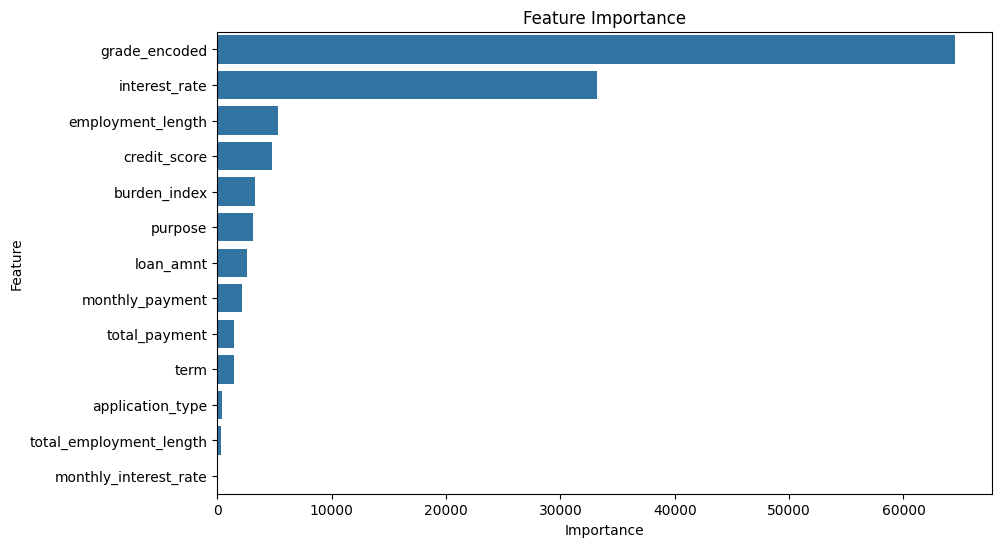

                    Feature    Importance
7             grade_encoded  64536.610383
2             interest_rate  33192.379066
3         employment_length   5347.987510
5              credit_score   4806.120086
11             burden_index   3270.202911
4                   purpose   3113.614519
0                 loan_amnt   2568.770869
9           monthly_payment   2167.455474
10            total_payment   1452.596882
1                      term   1448.073074
6          application_type    404.925931
12  total_employment_length    348.930061
8     monthly_interest_rate      0.000000


In [13]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


# データ読み込み
file_path = '/content/drive/My Drive/signate/train_1221_4.csv'
df = pd.read_csv(file_path, low_memory=False)

# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# 特徴量とターゲット
X = df.drop(columns=['loan_status', 'grade', 'term_months'])
y = df['loan_status']

# モデルのトレーニング（例としてLightGBMを仮定）
train_data = lgb.Dataset(X, label=y)
final_model = lgb.train({'objective': 'binary'}, train_data, num_boost_round=100)

# 特徴量重要度を取得
feature_importances = final_model.feature_importance(importance_type='gain')  # 'split' も選択可能
feature_names = final_model.feature_name()

# データフレームとして整理
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# 特徴量重要度を確認
print(importance_df)


# 実際のtestデータで予測する

In [22]:
import pandas as pd
import lightgbm as lgb

# ファイルパス
test_file_path = '/content/drive/My Drive/signate/test_1221_5.csv'
model_file_path = '/content/drive/My Drive/signate/lgbm_model_1221_5.txt'

# テストデータの読み込み
test_df = pd.read_csv(test_file_path, low_memory=False)


# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    test_df[col] = test_df[col].astype('category')

# 特徴量を抽出
X_test = test_df.drop(columns=['id', 'grade', 'term_months'], errors='ignore')  # 除外列をトレーニングデータと一致

# 保存したモデルを読み込む
final_model = lgb.Booster(model_file=model_file_path)

# テストデータの予測確率を取得
test_proba = final_model.predict(X_test)  # クラス1の確率を取得

# 最適閾値を設定
optimal_threshold =  0.19726323890446196  # トレーニングで計算した最適閾値を使用
test_predictions = (test_proba > optimal_threshold).astype(int)

# 提出用のデータフレーム作成
submission = pd.DataFrame({
    'id': test_df['id'],  # テストデータのID列
    'loan_status': test_predictions  # 予測結果
})

# CSVとして保存
submission_file_path = '/content/drive/My Drive/signate/submission1221_4.csv'
submission.to_csv(submission_file_path, index=False, header=False)  # ヘッダーを削除
print(f"Submission file saved to: {submission_file_path}")


Submission file saved to: /content/drive/My Drive/signate/submission1221_4.csv


In [23]:
import pandas as pd

# CSVファイルを読み込む
file_path = '/content/drive/My Drive/signate/submission1221_4.csv'
test_df = pd.read_csv(file_path, low_memory=False)

test_df.head(30)

,1496754,0
0,84909594,0
1,1165403,0
2,91354446,1
3,85636932,1
4,1320109,0
5,91934646,0
6,121902070,1
7,92074399,1
8,1267960,0
9,86983900,1


# catboostでトレーニングする

In [24]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 22.9 MB/s eta 0:00:00


# optunaで最適なパラメータを探す

In [25]:
import optuna
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, f1_score

# データ読み込み
file_path = '/content/drive/My Drive/signate/train_1221_5.csv'
df = pd.read_csv(file_path, low_memory=False)

# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# 特徴量とターゲット
X = df.drop(columns=['loan_status', 'grade', 'term_months'])
y = df['loan_status']

# 欠損値の確認と処理
if X.isnull().sum().sum() > 0:
    print("Warning: Missing values found in features. Consider handling them explicitly.")

# Optunaの目的関数
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 3000),
        'depth': trial.suggest_int('depth', 10, 16),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 15),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'eval_metric': 'F1',
        'use_best_model': True,
        'random_seed': 42,
        'verbose': 0
    }

    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # 欠損値の処理
        train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
        val_pool = Pool(X_val, y_val, cat_features=categorical_columns)

        # モデルのトレーニング
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=0)

        # 閾値調整
        y_pred_prob = model.predict_proba(X_val)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)

        # F1スコア計算の安定化
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores = np.nan_to_num(f1_scores)  # NaNを0に変換
        if len(thresholds) == 0:  # 念のためのエッジケース対応
            continue
        best_threshold = thresholds[np.argmax(f1_scores)]

        # 最適閾値で予測
        y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)
        scores.append(f1_score(y_val, y_pred_adjusted))

    # 平均F1スコアを返す
    return np.mean(scores) if len(scores) > 0 else 0

# Optunaの最適化
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 最適パラメータの確認
print("Best params:", study.best_params)
print("Best F1 score:", study.best_value)


[I 2024-12-21 05:10:19,920] A new study created in memory with name: no-name-bd286658-845d-48d4-9aa2-fbf0ca9238da


<ipython-input-25-0e0c72cff0bc>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
[I 2024-12-21 05:15:31,567] Trial 0 finished with value: 0.3925691992465418 and parameters: {'iterations': 1068, 'depth': 16, 'learning_rate': 0.006219061172713787, 'l2_leaf_reg': 4.245485231194917, 'border_count': 202, 'bagging_temperature': 5.428686094929823, 'random_strength': 4.181185673023396}. Best is trial 0 with value: 0.3925691992465418.
<ipython-input-25-0e0c72cff0bc>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
<ipython-input-25-0e0c72cff0bc>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
[I 2024-12-21 05:16:47,886] Trial 1 finished with value: 0.40120662028974446 and parameters: {'iterations': 1113, 'depth': 12, 'learning_rate': 0.001060007909740343, 'l2_leaf_reg': 9.510631197957554, '

KeyboardInterrupt: 

# 最適なパラメータでトレーニングする

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool


# データ読み込み
file_path = '/content/drive/My Drive/signate/train_1221_5.csv'
df = pd.read_csv(file_path, low_memory=False)

# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# 特徴量とターゲット
X = df.drop(columns=['loan_status', 'grade', 'term_months'])
y = df['loan_status']

# 欠損値の確認と処理
if X.isnull().sum().sum() > 0:
    print("Warning: Missing values found in features. Consider handling them explicitly.")

# トレーニングデータと検証データに分割
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Poolオブジェクトを作成
train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
eval_pool = Pool(X_eval, y_eval, cat_features=categorical_columns)

# 最適パラメータを設定
best_params = {
    'iterations': 531,
    'depth': 11,
    'learning_rate': 0.06382731423716013,
    'l2_leaf_reg': 8.96608380944381,
    'border_count': 102,
    'bagging_temperature': 4.092390774597465,
    'random_strength': 2.298108915615952,
    'eval_metric': 'F1',
    'use_best_model': True,
    'random_seed': 42
}

# モデルのトレーニング
final_model = CatBoostClassifier(**best_params)
final_model.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=100, verbose=50)

# 検証データで予測確率を取得
eval_proba = final_model.predict_proba(eval_pool)[:, 1]  # クラス1の確率を取得

# Precision-Recall Curve を使用して最適な閾値を計算
precision, recall, thresholds = precision_recall_curve(y_eval, eval_proba)

# F1スコアの計算
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)  # NaNを0に変換

# 最適な閾値
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold: {optimal_threshold}")

# 最適な閾値でF1スコアを計算
y_pred_adjusted = (eval_proba >= optimal_threshold).astype(int)
final_f1_score = f1_score(y_eval, y_pred_adjusted)
print(f"Final F1 Score with Optimal Threshold: {final_f1_score}")

# モデルを保存
model_file_path = '/content/drive/My Drive/signate/catboost_model_1221_1.cbm'
final_model.save_model(model_file_path)
print(f"Model saved to: {model_file_path}")


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 103ms	remaining: 54.8s
50:	learn: 0.0372674	test: 0.0363199	best: 0.0374975 (47)	total: 4.44s	remaining: 41.8s
100:	learn: 0.0711079	test: 0.0670435	best: 0.0670435 (100)	total: 9.52s	remaining: 40.5s
150:	learn: 0.0824288	test: 0.0733359	best: 0.0741243 (149)	total: 13.6s	remaining: 34.2s
200:	learn: 0.0935543	test: 0.0774268	best: 0.0774268 (200)	total: 17.7s	remaining: 29.1s
250:	learn: 0.1069695	test: 0.0806513	best: 0.0810655 (248)	total: 23s	remaining: 25.7s
300:	learn: 0.1202593	test: 0.0868158	best: 0.0868158 (300)	total: 28.4s	remaining: 21.7s
350:	learn: 0.1337359	test: 0.0904866	best: 0.0905123 (346)	total: 33.8s	remaining: 17.3s
400:	learn: 0.1451696	test: 0.0948699	best: 0.0948699 (400)	total: 39s	remaining: 12.7s
450:	learn: 0.1570795	test: 0.0975976	best: 0.0986774 (449)	total: 44.1s	remaining: 7.83s
500:	learn: 0.1671001	test: 0.0989135	best: 0.0995314 (469)	total: 49.7s	remaining: 2.98s
530:	learn: 0.172966

<ipython-input-26-0ad62f4f9652>:57: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


# 実際のテストデータで予測する

In [27]:
import pandas as pd
from catboost import CatBoostClassifier, Pool

# ファイルパス
test_file_path = '/content/drive/My Drive/signate/test_1221_5.csv'
cat_model_file_path = '/content/drive/My Drive/signate/catboost_model_1221_1.cbm'

# テストデータの読み込み
test_df = pd.read_csv(test_file_path, low_memory=False)

# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    test_df[col] = test_df[col].astype('category')

# 特徴量を抽出
X_test = test_df.drop(columns=['id', 'grade', 'term_months'], errors='ignore')  # 除外列をトレーニングデータと一致

# Poolオブジェクトを作成
test_pool = Pool(X_test, cat_features=categorical_columns)

# 保存したモデルを読み込む
final_model = CatBoostClassifier()
final_model.load_model(model_file_path)

# テストデータの予測確率を取得
test_proba = final_model.predict_proba(test_pool)[:, 1]  # クラス1の確率を取得

# 最適閾値を設定
optimal_threshold = 0.21294587588263655  # トレーニングで計算した最適閾値を使用
test_predictions = (test_proba > optimal_threshold).astype(int)

# 提出用のデータフレーム作成
submission = pd.DataFrame({
    'id': test_df['id'],  # テストデータのID列
    'loan_status': test_predictions  # 予測結果
})

# CSVとして保存
submission_file_path = '/content/drive/My Drive/signate/submission1221_7.csv'
submission.to_csv(submission_file_path, index=False, header=False)  # ヘッダーを削除
print(f"Submission file saved to: {submission_file_path}")


Submission file saved to: /content/drive/My Drive/signate/submission1221_7.csv


In [28]:
import pandas as pd

# CSVファイルを読み込む
file_path = '/content/drive/My Drive/signate/submission1221_7.csv'
test_df = pd.read_csv(file_path, low_memory=False)

test_df.head(30)

,1496754,0
0,84909594,0
1,1165403,0
2,91354446,1
3,85636932,1
4,1320109,0
5,91934646,0
6,121902070,1
7,92074399,1
8,1267960,0
9,86983900,1


# アンサンブルモデルを作成する

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve
from catboost import CatBoostClassifier

# データ読み込み
file_path = '/content/drive/My Drive/signate/train_with_features.csv'
df = pd.read_csv(file_path, low_memory=False)

# LightGBMモデルを読み込む
lgbm_model_file_path = '/content/drive/My Drive/signate/lgbm_model_1219_2.txt'
lgbm_model = lgb.Booster(model_file=lgbm_model_file_path)

# CatBoostモデルを読み込む
cat_model_file_path = '/content/drive/My Drive/signate/catboost_model_1219_1.cbm'
cat_model = CatBoostClassifier()
cat_model.load_model(cat_model_file_path)

# カテゴリカル列
categorical_columns = ['grade', 'purpose', 'application_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# 特徴量とターゲット
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# データ分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# カテゴリカル型が保持されているか確認
print(X_val.dtypes)

# LightGBMの予測確率
lgbm_preds = lgbm_model.predict(X_val)

# CatBoostの予測確率
cat_preds = cat_model.predict_proba(X_val)[:, 1]  # クラス1の確率

# アンサンブル
lgbm_weight = 0.5
cat_weight = 0.5
ensemble_preds = lgbm_weight * lgbm_preds + cat_weight * cat_preds

# Precision-Recall Curveを使って最適な閾値を計算
precision, recall, thresholds = precision_recall_curve(y_val, ensemble_preds)
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

if len(thresholds) > 0:
    best_threshold = thresholds[f1_scores.index(max(f1_scores))]
else:
    best_threshold = 0.5  # デフォルト閾値

# 最終予測
final_preds = (ensemble_preds > best_threshold).astype(int)

# F1スコアの評価
ensemble_f1 = f1_score(y_val, final_preds)
print(f"Ensemble Model F1 Score: {ensemble_f1}")


loan_amnt                 float64
term                      float64
interest_rate             float64
grade                    category
employment_length         float64
purpose                  category
credit_score              float64
application_type         category
monthly_interest_rate     float64
term_months               float64
monthly_payment           float64
total_payment             float64
burden_index              float64
dtype: object
Ensemble Model F1 Score: 0.4350337532187348


Best Threshold: 0.21791771931677495
Best F1 Score: 0.43507306889352815


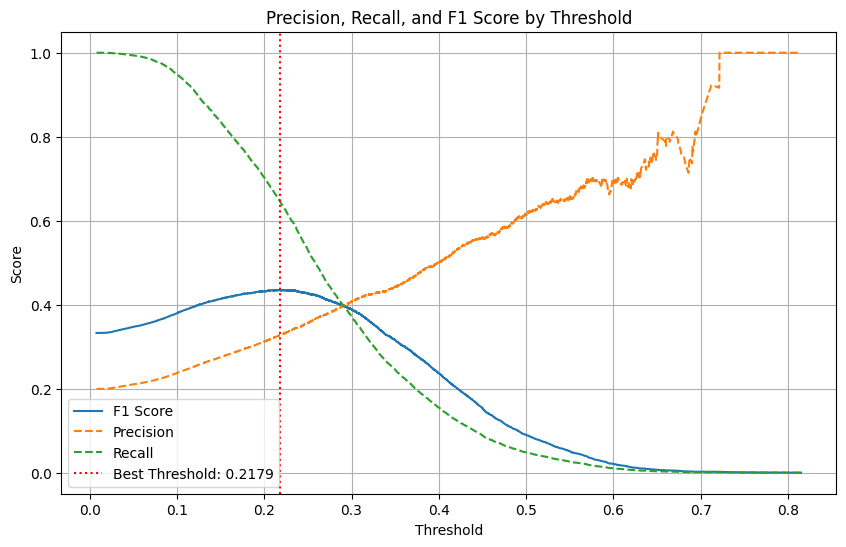

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Precision-Recall Curveを計算
precision, recall, thresholds = precision_recall_curve(y_val, ensemble_preds)

# F1スコアを計算
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

# 最適な閾値を取得
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

# 結果を出力
print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1_score}")

# グラフで可視化
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')  # 最後のスコアに対応する閾値はない
plt.plot(thresholds, precision[:-1], label='Precision', linestyle='--')
plt.plot(thresholds, recall[:-1], label='Recall', linestyle='--')
plt.axvline(best_threshold, color='r', linestyle=':', label=f'Best Threshold: {best_threshold:.4f}')
plt.title('Precision, Recall, and F1 Score by Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve

# 検証データで予測
val_preds = ensemble_preds   # アンサンブルモデルの検証データ予測結果

# Precision-Recall Curveを計算
precision, recall, thresholds = precision_recall_curve(y_val, val_preds)
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

# F1スコアが最大となる閾値を選択
best_threshold = thresholds[f1_scores.index(max(f1_scores))]
print(f"Optimal Threshold from Validation Data: {best_threshold}")


Optimal Threshold from Validation Data: 0.21791771931677495


In [ ]:
# LightGBMモデルを読み込む
lgbm_model_file_path = '/content/drive/My Drive/signate/lgbm_model_1219_2.txt'
lgbm_model = lgb.Booster(model_file=lgbm_model_file_path)

# CatBoostモデルを読み込む
cat_model_file_path = '/content/drive/My Drive/signate/catboost_model_1219_1.cbm'
cat_model = CatBoostClassifier()
cat_model.load_model(cat_model_file_path)

# テストデータの読み込み
test_file_path = '/content/drive/My Drive/signate/test_with_features.csv'
test_df = pd.read_csv(test_file_path, low_memory=False)

# カテゴリカル列の型変換
categorical_columns = ['grade', 'purpose', 'application_type']
for col in categorical_columns:
    test_df[col] = test_df[col].astype('category')

# 特徴量を抽出
X_test = test_df.drop(columns=['id'])  # 必要に応じて除外する列を調整

# LightGBMとCatBoostの予測確率
lgbm_preds_test = lgbm_model.predict(X_test)
cat_preds_test = cat_model.predict_proba(X_test)[:, 1]

# アンサンブル
lgbm_weight = 0.5
cat_weight = 0.5
ensemble_preds_test = lgbm_weight * lgbm_preds_test + cat_weight * cat_preds_test

# 最適閾値でクラス予測
best_threshold = 0.217
final_test_preds = (ensemble_preds_test > best_threshold).astype(int)

# 提出用のデータフレーム作成
submission = pd.DataFrame({
    'id': test_df['id'],  # テストデータのID列
    'loan_status': final_test_preds  # 予測結果
})

# 結果の保存
output_file_path = '/content/drive/My Drive/signate/submission1219_7.csv'
submission.to_csv(output_file_path, index=False, header=False)

print(f"Predictions saved to: {output_file_path}")


Predictions saved to: /content/drive/My Drive/signate/submission1219_7.csv


In [ ]:
import pandas as pd

# CSVファイルを読み込む
file_path = '/content/drive/My Drive/signate/submission1219_7.csv'
test_df = pd.read_csv(file_path, low_memory=False)

test_df.head(30)

,1496754,0
0,84909594,0
1,1165403,0
2,91354446,1
3,85636932,1
4,1320109,0
5,91934646,0
6,121902070,1
7,92074399,1
8,1267960,0
9,86983900,1
